# Marcin Socha nr 418253

Na początku zaimportujmy potrzebne biblioteki

In [2]:
import pandas as pd
import numpy as np
import os
import importlib
import external_func
importlib.reload(external_func)

from external_func import *



Teraz wczytujemy odczytujemy nazwy plików oraz zapisujemy dane z folderu do tabeli pliki = {}

In [3]:
folder = 'data'
nazwy_plikow = pobierz_nazwy_plikow(folder)
print(nazwy_plikow)
pliki = {}
for nazwa_pliku in nazwy_plikow:
    wczytaj_dane(folder, nazwa_pliku, pliki)

['title.ratings.tsv', 'title.principals.tsv', 'title.akas.tsv', 'name.basics.tsv', 'title.basics.tsv', 'title.episode.tsv', 'title.crew.tsv']


/Users/machoranis/Programowanie/NYPD/NYPD-Final_project/external_func.py:13: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(pelna_nazwa, sep='\t')


Sprawdzamy nazwy plików...

In [4]:
klucze = [s[:-4].replace('.', '_') for s in nazwy_plikow]
klucze

['title_ratings',
 'title_principals',
 'title_akas',
 'name_basics',
 'title_basics',
 'title_episode',
 'title_crew']

... oraz nazwy kolumn w nich zawarte.

In [5]:
for i in range(len(klucze)):
    print(pliki[klucze[i]].columns)

Index(['tconst', 'averageRating', 'numVotes'], dtype='object')
Index(['tconst', 'ordering', 'nconst', 'category', 'job', 'characters'], dtype='object')
Index(['titleId', 'ordering', 'title', 'region', 'language', 'types',
       'attributes', 'isOriginalTitle'],
      dtype='object')
Index(['nconst', 'primaryName', 'birthYear', 'deathYear', 'primaryProfession',
       'knownForTitles'],
      dtype='object')
Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres'],
      dtype='object')
Index(['tconst', 'parentTconst', 'seasonNumber', 'episodeNumber'], dtype='object')
Index(['tconst', 'directors', 'writers'], dtype='object')


# tworzenie metryki
Uznałem, ze najlepszą metryką będzie średnia harmoniczna z averageRating * log(numVotes), poniewaz srednia harmoniczna jest zawsze nizsza od sredniej arytmetycznej i dla stałej średniej arytmetyczniej osiąga maksimum gdy wszystkie oceny są równe, więc faworyzujemy niskie odchylenia. Z kolei log(numVotes), poniewaz wydaje się, ze jest to podobny poziom dla
tego samego rzędu wielkości, ale jednak faworyzuje trochę filmy popularniejsze. Np wezmy pod uwagę film ze srednią 9.1 i 100k głosów oraz film 8.9 z 130k głosów. Wówczas wg naszej metryki ocena będzie równa

In [6]:
pie = 9.1 * (np.log(100000))
dru = 8.9 * (np.log(130000))
print("Pierwszy ma ocenę ",pie, ", zaś drugi ", dru)

Pierwszy ma ocenę  104.76762173122907 , zaś drugi  104.80007859199571


Stąd widzimy, ze "ludzkim okiem" nasza metryka ma sens.

# Task 1

Wczytajmy dane z pierwszego pliku z kolumnami potrzebnymi do stworzenia metryki

In [7]:
title_ratings = pliki[klucze[0]]

Dodajmy kolumnę quality, która liczy naszą metrykę dla kazdego filmu

In [8]:
title_ratings['quality'] = title_ratings['averageRating'] * np.log(title_ratings['numVotes'])

Sprawdźmy jak wygląda początek tej tabeli, zeby upewnić się, czy dobrze ją zapisaliśmy.

In [9]:
title_ratings.head(5)

,tconst,averageRating,numVotes,quality
0,tt0000001,5.7,2063,43.501924
1,tt0000002,5.6,279,31.534786
2,tt0000003,6.5,2030,49.502642
3,tt0000004,5.4,180,28.041967
4,tt0000005,6.2,2796,49.202860


Następnie wczytujemy tabelę z danymi dotyczącymi nazwy tytułu oraz jego typem.

In [10]:
title_principals = pliki[klucze[4]]
title_principals.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


Łączymy te dwie tabele leftjoinem ze względu na pierwszą.

In [11]:
title_r_p = title_ratings.merge(title_principals, left_on='tconst', right_on='tconst', how='left')

Sprawdzamy jakie typy produkcji filmowych są w naszej bazie danych.

In [12]:
title_r_p['titleType'].unique()

array(['short', 'movie', 'tvShort', 'tvMovie', 'tvSeries', 'tvEpisode',
       'tvMiniSeries', 'tvSpecial', 'video', 'videoGame'], dtype=object)

Poniewaz chcemy porownywać ze sobą filmy zostawiamy jedynie movie oraz tvMovie. Posortujemy teraz filmy od najlpeszego do najgorszego według naszej metryki.

In [87]:
title_r_p = title_r_p[title_r_p['titleType'].isin(['movie', 'tvMovie'])]
title_r_p.sort_values('quality', ascending=False).reset_index().head(20)

,level_0,index,tconst,averageRating,numVotes,quality,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,67708,83943,tt0111161,9.3,2912371,138.425646,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama
1,159653,255737,tt0468569,9.0,2893597,133.902098,movie,The Dark Knight,The Dark Knight,0,2008,\N,152,"Action,Crime,Drama"
2,38068,47432,tt0068646,9.2,2029452,133.614143,movie,The Godfather,The Godfather,0,1972,\N,175,"Crime,Drama"
3,87665,116492,tt0167260,9.0,1994127,130.551452,movie,The Lord of the Rings: The Return of the King,The Lord of the Rings: The Return of the King,0,2003,\N,201,"Action,Adventure,Drama"
4,67516,83726,tt0110912,8.9,2238375,130.129220,movie,Pulp Fiction,Pulp Fiction,0,1994,\N,154,"Crime,Drama"
5,211805,665929,tt1375666,8.8,2570529,129.884676,movie,Inception,Inception,0,2010,\N,148,"Action,Adventure,Sci-Fi"
6,73632,91757,tt0120737,8.9,2022740,129.227676,movie,The Lord of the Rings: The Fellowship of the Ring,The Lord of the Rings: The Fellowship of the Ring,0,2001,\N,178,"Action,Adventure,Drama"
7,79506,100688,tt0137523,8.8,2345337,129.077869,movie,Fight Club,Fight Club,0,1999,\N,139,Drama
8,66781,82844,tt0109830,8.8,2277257,128.818643,movie,Forrest Gump,Forrest Gump,0,1994,\N,142,"Drama,Romance"
9,65745,81342,tt0108052,9.0,1462031,127.758034,movie,Schindler's List,Schindler's List,0,1993,\N,195,"Biography,Drama,History"


Aby znaleźć miejsce produkcji filmu sprawdźmy, które filmy posiadają oryginalne tytuły.
Będziemy do tego potrzebowali dwóch tabeli: title_akas oraz title_akas_ot (original title), czyli tylko tę z oryginalnymi tytułami.
Poniewaz rzad, w ktorym jest isOriginalTitle nie mowi nam o kraju pochodzenia laczymy dwie tabele,
szukając w ktorych regionach tytuł był taki sam jak oryginalny

In [15]:
title_akas = pliki[klucze[2]]
title_akas_ot = title_akas[title_akas['isOriginalTitle'] == 1] #originaltitle
title_akas_ot = title_akas.merge(title_akas_ot, left_on='titleId', right_on='titleId', how='left')
title_akas_ot.head(20)

,titleId,ordering_x,title_x,region_x,language_x,types_x,attributes_x,isOriginalTitle_x,ordering_y,title_y,region_y,language_y,types_y,attributes_y,isOriginalTitle_y
0,tt0000001,1,Carmencita,\N,\N,original,\N,1,1.0,Carmencita,\N,\N,original,\N,1.0
1,tt0000001,2,Carmencita,DE,\N,\N,literal title,0,1.0,Carmencita,\N,\N,original,\N,1.0
2,tt0000001,3,Carmencita,US,\N,imdbDisplay,\N,0,1.0,Carmencita,\N,\N,original,\N,1.0
3,tt0000001,4,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0,1.0,Carmencita,\N,\N,original,\N,1.0
4,tt0000001,5,Καρμενσίτα,GR,\N,imdbDisplay,\N,0,1.0,Carmencita,\N,\N,original,\N,1.0
5,tt0000001,6,Карменсита,RU,\N,imdbDisplay,\N,0,1.0,Carmencita,\N,\N,original,\N,1.0
6,tt0000001,7,Карменсіта,UA,\N,imdbDisplay,\N,0,1.0,Carmencita,\N,\N,original,\N,1.0
7,tt0000001,8,カルメンチータ,JP,ja,imdbDisplay,\N,0,1.0,Carmencita,\N,\N,original,\N,1.0
8,tt0000002,1,Le clown et ses chiens,\N,\N,original,\N,1,1.0,Le clown et ses chiens,\N,\N,original,\N,1.0
9,tt0000002,2,A bohóc és kutyái,HU,\N,imdbDisplay,\N,0,1.0,Le clown et ses chiens,\N,\N,original,\N,1.0


Następnie usuwamy wszystkie filmy, ktore nie wiadomo skąd pochodzą oraz dla przejrzystości zostawiamy jedynie potrzebne kolumny: z tytułem oraz krajem pochodzenia.

In [19]:
title_akas_ot = title_akas_ot[title_akas_ot['region_x'] != '\\N']
title_akas_ot_short = title_akas_ot[['titleId', 'region_x']]
title_akas_ot_short.head(5)

,titleId,region_x
1,tt0000001,DE
2,tt0000001,US
3,tt0000001,HU
4,tt0000001,GR
5,tt0000001,RU


Zauwazmy jednak, ze ze nie da się przyporządkować jednego regionu do jednego tytułu w ten sposób. Niemniej jednak ciezko zweryfikowac w inny sposób skąd pochodzi dana produkcja.
Następnie połączmy title_r_p z title_akas_ot_short, zamieńmy nazwę region_x na przyjemniejszą region oraz posortujmy filmy od najlpeszego do najgorszego.

In [21]:
title_akas_ot_short = title_r_p.merge(title_akas_ot_short, left_on='tconst', right_on='titleId', how='left')
title_akas_ot_short = title_akas_ot_short.rename(columns={'region_x': 'region'})
title_akas_ot_short = title_akas_ot_short.sort_values('quality', ascending=False)

In [22]:
title_akas_ot_short.head(10)

,tconst,averageRating,numVotes,quality,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,titleId,region
738872,tt0111161,9.3,2912371,138.425646,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,tt0111161,LT
738873,tt0111161,9.3,2912371,138.425646,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,tt0111161,IR
738863,tt0111161,9.3,2912371,138.425646,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,tt0111161,RO
738864,tt0111161,9.3,2912371,138.425646,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,tt0111161,HR
738865,tt0111161,9.3,2912371,138.425646,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,tt0111161,SI
738866,tt0111161,9.3,2912371,138.425646,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,tt0111161,IT
738867,tt0111161,9.3,2912371,138.425646,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,tt0111161,FR
738868,tt0111161,9.3,2912371,138.425646,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,tt0111161,VN
738869,tt0111161,9.3,2912371,138.425646,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,tt0111161,SE
738870,tt0111161,9.3,2912371,138.425646,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,tt0111161,PT


Następnie dla kadej produkcji przypiszmy im kraje pochodzenie w jednej kolumnie.

In [39]:
# Group by 'title' and 'quality', and aggregate 'region' into a list
grouped_df = title_akas_ot_short.groupby(['tconst', 'primaryTitle', 'quality'])['region'].agg(list).reset_index()

# Print the resulting DataFrame
#grouped_df['categorized_region'] = grouped_df['region'].apply(categorize_region)
grouped_df = grouped_df[grouped_df['region'].apply(lambda x: not any(isinstance(i, float) and np.isnan(i) for i in x))]

grouped_df

,tconst,primaryTitle,quality,region
0,tt0000009,Miss Jerry,28.925566,"[AU, US, DE, HU]"
1,tt0000147,The Corbett-Fitzsimmons Fight,32.489823,"[US, RU]"
2,tt0000502,Bohemios,12.139561,[ES]
3,tt0000574,The Story of the Kelly Gang,40.906983,"[AU, SG, GB, AU, HU, DE, US, RS]"
4,tt0000591,The Prodigal Son,17.919531,"[US, FR]"
...,...,...,...,...
366084,tt9916428,The Secret of China,10.599980,"[RU, XWW, CN, GB, US]"
366085,tt9916460,Pink Taxi,26.205507,[GR]
366086,tt9916538,Kuambil Lagi Hatiku,18.236964,[ID]
366087,tt9916706,Dankyavar Danka,12.231728,[IN]


Następnie za pomocą funkcji categorize_region zamienimy wszystkie zbiory regionów, ktore są anglojęzyczne na English, US bądź GB (patrz: plik z funkcjami).

In [40]:
grouped_df['categorized_region'] = grouped_df['region'].apply(categorize_region)
grouped_df = grouped_df.drop('region', axis=1)
grouped_df = grouped_df.rename(columns={'categorized_region': 'region'})
grouped_df


,tconst,primaryTitle,quality,region
0,tt0000009,Miss Jerry,28.925566,US
1,tt0000147,The Corbett-Fitzsimmons Fight,32.489823,US
2,tt0000502,Bohemios,12.139561,ES
3,tt0000574,The Story of the Kelly Gang,40.906983,English
4,tt0000591,The Prodigal Son,17.919531,US
...,...,...,...,...
366084,tt9916428,The Secret of China,10.599980,English
366085,tt9916460,Pink Taxi,26.205507,GR
366086,tt9916538,Kuambil Lagi Hatiku,18.236964,ID
366087,tt9916706,Dankyavar Danka,12.231728,IN


In [41]:
grouped_df['region'] = grouped_df['region'].str.split(',')
df_exploded = grouped_df.explode('region')

,tconst,primaryTitle,quality,region
0,tt0000009,Miss Jerry,28.925566,US
1,tt0000147,The Corbett-Fitzsimmons Fight,32.489823,US
2,tt0000502,Bohemios,12.139561,ES
3,tt0000574,The Story of the Kelly Gang,40.906983,English
4,tt0000591,The Prodigal Son,17.919531,US
5,tt0000615,Robbery Under Arms,13.358196,AU
6,tt0000630,Hamlet,9.330173,US
7,tt0000675,Don Quijote,12.178090,ES
8,tt0000679,The Fairylogue and Radio-Plays,22.381138,English
9,tt0000838,A Cultura do Cacau,7.673265,BR


Teraz dla kadego regionu stworzymy top n=10,20,...,200 jego najlepszych filmów i policzymy ich średnią harmoniczną. Następnie stworzymy top 10 regionów pod tym względem. Na końcu pokaemy na wizualizacji jak zmieniało się top 10 na przestrzeni n=10,20,...200.

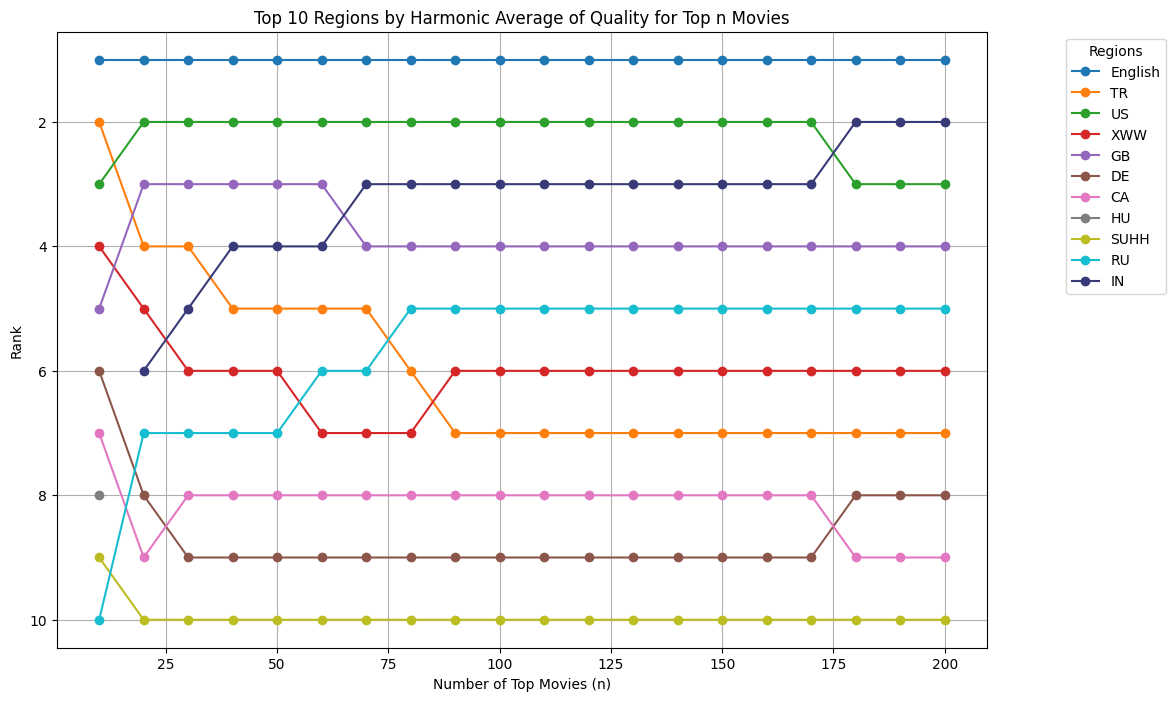

In [49]:
# List to store results for plotting
region_rankings = {}

# Define a color palette with 20 colors
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#393b79', '#637939', '#8c6d31', '#843c39', '#7b4173',
    '#ce6dbd', '#6b6ecf', '#b5cf6b', '#bd9e39', '#9c9ede'
]

# Create a mapping of region to color
region_color_map = {}

# Loop over different values of n
for n in range(10, 210, 10):
    region_harmonic_averages = []

    # Calculate the harmonic average for each region
    for region, group in df_exploded.groupby('region'):
        if len(group) >= n:
            top_n_movies = group.nlargest(n, 'quality')
            harmonic_avg = harmonic_average(top_n_movies['quality'])
            region_harmonic_averages.append((region, harmonic_avg))

    # Sort regions by harmonic average
    region_harmonic_averages.sort(key=lambda x: x[1], reverse=True)

    # Store the rankings
    for rank, (region, avg) in enumerate(region_harmonic_averages[:10], start=1):
        if region not in region_rankings:
            region_rankings[region] = []
        region_rankings[region].append((n, rank))
        # Assign a color to each region
        if region not in region_color_map:
            color_index = len(region_color_map) % len(colors)
            region_color_map[region] = colors[color_index]

# Plotting the rankings
plt.figure(figsize=(12, 8))
regions_to_plot = {region: ranks for region, ranks in region_rankings.items() if ranks}

for region, ranks in regions_to_plot.items():
    n_vals, rank_vals = zip(*ranks)
    plt.plot(n_vals, rank_vals, marker='o', label=region, color=region_color_map[region])

plt.gca().invert_yaxis()  # Invert y-axis to have rank 1 at the top
plt.xlabel('Number of Top Movies (n)')
plt.ylabel('Rank')
plt.title('Top 10 Regions by Harmonic Average of Quality for Top n Movies')
plt.legend(title='Regions', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()

# Task 2
Na początku musimy znowu połączyć tabelę z numVotes, eby policzyć weak impact

### Weak Impact

In [62]:
weak_impact = df_exploded.merge(title_ratings, left_on='tconst', right_on='tconst', how='left')

In [91]:
wi = weak_impact.groupby('region')['numVotes'].sum().reset_index()

# Sort by the sum of 'quality' in descending order to create a ranking
ranking_weak_impact = wi.sort_values(by='numVotes', ascending=False).reset_index(drop=True)

# Add a ranking column
ranking_weak_impact['Rank'] = ranking_weak_impact.index + 1

# Display the ranking
print(ranking_weak_impact)

print('Miejsce Polski w tym rankingu to: ', ranking_weak_impact[ranking_weak_impact['region'] == 'PL'].index + 1)


      region    numVotes  Rank
0    English  1109696955     1
1         US    16819447     2
2         IN     6783194     3
3         RU     5479955     4
4         GB     5432232     5
..       ...         ...   ...
210       NC          11   211
211       SC           9   212
212       KM           8   213
213       EH           5   214
214       VU           5   215

[215 rows x 3 columns]
Miejsce Polski w tym rankingu to:  Index([9], dtype='int64')


### Strong impact

In [89]:

region_harmonic_averages = df_exploded.groupby('region')['quality'].agg(harmonic_average).reset_index()
region_harmonic_averages.columns = ['region', 'strongImpact']
region_harmonic_averages = region_harmonic_averages.sort_values(by='strongImpact', ascending=False)
region_harmonic_averages = region_harmonic_averages.reset_index()
region_harmonic_averages

,index,region,strongImpact
0,127,MQ,30.273787
1,112,LT,28.909528
2,61,English,28.771399
3,6,AN,28.176875
4,143,OM,27.537433
...,...,...,...
210,100,KM,8.941599
211,197,VI,8.536413
212,162,SC,7.910008
213,74,GQ,7.734860


Mozna tez sprawdzić, ze dla średniej kwadratowej większe znaczenie ma liczba dobrych filmów niz szansa na "niefrafienie słabego dzieła".

In [90]:
region_harmonic_averages = df_exploded.groupby('region')['quality'].agg(quadratic_average).reset_index()
region_harmonic_averages.columns = ['region', 'strongImpact']
region_harmonic_averages = region_harmonic_averages.sort_values(by='strongImpact', ascending=False)
region_harmonic_averages = region_harmonic_averages.reset_index()
region_harmonic_averages

,index,region,strongImpact
0,61,English,39.782751
1,112,LT,35.407727
2,1,AE,34.184751
3,157,RS,33.551710
4,6,AN,33.358813
...,...,...,...
210,161,SB,10.376034
211,74,GQ,10.096492
212,100,KM,8.941599
213,162,SC,7.910008


Uzyjemy teraz danych ze strony World Bank Group https://datacatalog.worldbank.org/search/dataset/0038130 dotycząch GDP za rok 2024, które lekko nalezało przerobić, zeby mozna bylo poprawnie wczytac jako plik .csv.

In [118]:
GDP = pd.read_csv('GDP.csv')
GDP.head(5)

,region,id,fullName,GDP,Unnamed: 4
0,USA,1.0,United States,"27,360,935",NaN
1,CHN,2.0,China,"17,794,782",NaN
2,DEU,3.0,Germany,"4,456,081",NaN
3,JPN,4.0,Japan,"4,212,945",NaN
4,IND,5.0,India,"3,549,919",NaN


W takim razie będziemy potrzebowali jeszcze znalezionego gdzieś przekładu ze skrótów 3 literowych na 2 literowe. Znaleziony na https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv zaimportujemy do naszego notatnika.

In [119]:
abb = pd.read_csv('all.csv')
abb.head(5)

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


Teraz mozemy zamienić skróty na 2 literowe w GDP.

In [120]:
GDP = GDP.merge(abb, left_on='region', right_on='alpha-3', how='left')
GDP

,region_x,id,fullName,GDP,Unnamed: 4,name,alpha-2,alpha-3,country-code,iso_3166-2,region_y,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,USA,1.0,United States,"27,360,935",NaN,United States of America,US,USA,840.0,ISO 3166-2:US,Americas,Northern America,NaN,19.0,21.0,NaN
1,CHN,2.0,China,"17,794,782",NaN,China,CN,CHN,156.0,ISO 3166-2:CN,Asia,Eastern Asia,NaN,142.0,30.0,NaN
2,DEU,3.0,Germany,"4,456,081",NaN,Germany,DE,DEU,276.0,ISO 3166-2:DE,Europe,Western Europe,NaN,150.0,155.0,NaN
3,JPN,4.0,Japan,"4,212,945",NaN,Japan,JP,JPN,392.0,ISO 3166-2:JP,Asia,Eastern Asia,NaN,142.0,30.0,NaN
4,IND,5.0,India,"3,549,919",NaN,India,IN,IND,356.0,ISO 3166-2:IN,Asia,Southern Asia,NaN,142.0,34.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,PRK,NaN,"Korea, Dem. People's Rep.",-,NaN,"Korea, Democratic People's Republic of",KP,PRK,408.0,ISO 3166-2:KP,Asia,Eastern Asia,NaN,142.0,30.0,NaN
213,MNP,NaN,Northern Mariana Islands,-,NaN,Northern Mariana Islands,MP,MNP,580.0,ISO 3166-2:MP,Oceania,Micronesia,NaN,9.0,57.0,NaN
214,SSD,NaN,South Sudan,-,NaN,South Sudan,SS,SSD,728.0,ISO 3166-2:SS,Africa,Sub-Saharan Africa,Eastern Africa,2.0,202.0,14.0
215,VEN,NaN,"Venezuela, RB",-,NaN,"Venezuela, Bolivarian Republic of",VE,VEN,862.0,ISO 3166-2:VE,Americas,Latin America and the Caribbean,South America,19.0,419.0,5.0


Znajdźmy wszystkie kraje, które nie zostały "przeskalowane" na dwa znaki.

In [121]:
GDP[GDP['alpha-2'].isna()]

,region_x,id,fullName,GDP,Unnamed: 4,name,alpha-2,alpha-3,country-code,iso_3166-2,region_y,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
143,NAM,144.0,Namibia,"12,351",NaN,Namibia,NaN,NAM,516.0,ISO 3166-2:NA,Africa,Sub-Saharan Africa,Southern Africa,2.0,202.0,18.0
147,CHI,148.0,Channel Islands,"11,228",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149,XKX,150.0,Kosovo,"10,438",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Widzimy, ze nie są to znaczące kraje dla kinematografii wedle naszej wiedzy, więc mozemy je po prostu ignorować. Połączymy teraz 

# Task 3
Porownamy moich ulubionych tworców: rezysera Wesa Andersona, aktora Christiana Bale'a oraz aktora Edwarda Nortona. Za pomocą dostępnej wiedzy o roku urodzenia tych tworcow znajduje ich w naszej bazie danych.

In [ ]:
name_basics = pliki[klucze[3]]
wes_and = name_basics[name_basics['primaryName'].str.contains('Wes Anderson', na=False) & name_basics['birthYear'].str.contains('1969', case=False, na=False)]
chr_bal = name_basics[name_basics['primaryName'].str.contains('Christian Bale', na=False) & name_basics['birthYear'].str.contains('1974', case=False, na=False)]
edw_nor = name_basics[name_basics['primaryName'].str.contains('Edward Norton', na=False) & name_basics['birthYear'].str.contains('1969', case=False, na=False)]

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
26444,nm0027572,Wes Anderson,1969,\N,"director,writer,producer","tt0432283,tt0265666,tt8847712,tt0128445"


Zobaczmy w jakich filmach brali oni udział

In [ ]:
wes_and_movies = wes_and['knownForTitles'].iloc[0].split(',')
chr_bal_movies = chr_bal['knownForTitles'].iloc[0].split(',')
edw_nor_movies = edw_nor['knownForTitles'].iloc[0].split(',')


In [ ]:
pom1 = df[df['tconst'].isin(wes_and_movies)]

# Wyświetlanie wyników
print(pom1[['tconst', 'quality']])

            tconst    quality
96390    tt0128445  92.727866
164609   tt0265666  96.211758
241326   tt0432283  98.882968
1412721  tt8847712  84.717930


znajdzmy indeks naszych twórców

In [ ]:
print('Wes: ', wes_and['nconst'], ', Chris: ', chr_bal['nconst'], ', Edward: ', edw_nor['nconst'])

Wes:  26444    nm0027572
Name: nconst, dtype: object , Chris:  287    nm0000288
Name: nconst, dtype: object , Edward:  1568    nm0001570
Name: nconst, dtype: object


In [ ]:
title_akas = pliki[klucze[2]]
wes_and_title_akas = title_akas[title_akas['titleId'].isin(wes_and_movies)]
print(wes_and_title_akas[wes_and_title_akas['isOriginalTitle'] == 1]['title'])
chr_bal_title_akas = title_akas[title_akas['titleId'].isin(chr_bal_movies)]
print(chr_bal_title_akas[chr_bal_title_akas['isOriginalTitle'] == 1]['title'])
edw_nor_title_akas = title_akas[title_akas['titleId'].isin(edw_nor_movies)]
print(edw_nor_title_akas[edw_nor_title_akas['isOriginalTitle'] == 1]['title'])

1121984                                              Rushmore
1597204                                  The Royal Tenenbaums
2119652                                     Fantastic Mr. Fox
46454800    The French Dispatch of the Liberty, Kansas Eve...
Name: title, dtype: object
1937184             Batman Begins
2228783           The Dark Knight
13197211    The Dark Knight Rises
21655301          American Hustle
Name: title, dtype: object
1050723                                         Primal Fear
1083713                                  American History X
1155977                                          Fight Club
28443569    Birdman or (The Unexpected Virtue of Ignorance)
Name: title, dtype: object


In [ ]:
title_principals = pliki[klucze[1]]
ws_movies = title_principals[(title_principals['nconst'] == 'nm0027572') & (title_principals['category'] == 'director')]
ws_movies = ws_movies.merge(df3, left_on= 'tconst', right_on = 'tconst', how='left')
title_akas = title_akas[title_akas['isOriginalTitle'] == 1]
ws_movies = ws_movies.merge(title_akas, left_on='tconst', right_on='titleId', how='left')
ws_movies = ws_movies[ws_movies['titleType'].isin(['movie', 'tvMovie'])]
ws_movies =ws_movies[['tconst', 'nconst', 'quality', 'title']].drop_duplicates()
ws_movies

,tconst,nconst,quality,title
1,tt0115734,nm0027572,78.231875,Bottle Rocket
2,tt0128445,nm0027572,92.727866,Rushmore
3,tt0265666,nm0027572,96.211758,The Royal Tenenbaums
4,tt0362270,nm0027572,88.300746,The Life Aquatic with Steve Zissou
5,tt0432283,nm0027572,98.882968,Fantastic Mr. Fox
6,tt0838221,nm0027572,88.508759,The Darjeeling Limited
10,tt14230388,nm0027572,75.894141,Asteroid City
12,tt1748122,nm0027572,99.960888,Moonrise Kingdom
14,tt2278388,nm0027572,110.986955,The Grand Budapest Hotel
21,tt31800329,nm0027572,55.584725,The Wonderful Story of Henry Sugar and Three More


In [ ]:
title_principals = pliki[klucze[1]]
cb_movies = title_principals[(title_principals['nconst'] == 'nm0000288') & (title_principals['category'] == 'actor')]
cb_movies = cb_movies.merge(df3, left_on= 'tconst', right_on = 'tconst', how='left')
title_akas = title_akas[title_akas['isOriginalTitle'] == 1]
cb_movies = cb_movies.merge(title_akas, left_on='tconst', right_on='titleId', how='left')
cb_movies = cb_movies[cb_movies['titleType'].isin(['movie', 'tvMovie'])]
cb_movies =cb_movies[['quality', 'title']].drop_duplicates()
cb_movies

,quality,title
1,90.959818,Empire of the Sun
2,54.912110,Mio min Mio
4,60.965100,Treasure Island
5,44.054161,A Murder of Quality
6,69.212387,Newsies
7,65.433774,Swing Kids
8,80.790565,Little Women
9,42.213003,Prince of Jutland
10,81.924915,Pocahontas
11,58.599182,The Portrait of a Lady


Wes Anderson score is:  70.98071067820393


In [ ]:
['quality']

# Remove NaN values (if any)
quality_values = quality_values.dropna()

# Convert to a numpy array for compatibility with the harmonic average function
quality_values = np.array(quality_values)

# Calculate the harmonic average
harmonic_avg = harmonic_average(quality_values)

In [ ]:
title_principals = pliki[klucze[1]]
en_movies = title_principals[(title_principals['nconst'] == 'nm0001570') & (title_principals['category'] == 'actor')]
en_movies = en_movies.merge(df3, left_on= 'tconst', right_on = 'tconst', how='left')
title_akas = title_akas[title_akas['isOriginalTitle'] == 1]
en_movies = en_movies.merge(title_akas, left_on='tconst', right_on='titleId', how='left')
en_movies = en_movies[en_movies['titleType'].isin(['movie', 'tvMovie'])]
en_movies =en_movies[['tconst', 'nconst', 'quality', 'title']].drop_duplicates()
en_movies

,tconst,nconst,quality,title
0,tt0116242,nm0001570,70.928931,Everyone Says I Love You
1,tt0117318,nm0001570,84.130569,The People vs. Larry Flynt
2,tt0117381,nm0001570,95.673794,Primal Fear
4,tt0120586,nm0001570,118.932956,American History X
5,tt0128442,nm0001570,87.515150,Rounders
6,tt0137523,nm0001570,129.077869,Fight Club
7,tt0141699,nm0001570,37.758652,Out of the Past
8,tt0171433,nm0001570,69.661027,Keeping the Faith
9,tt0227445,nm0001570,80.311608,The Score
11,tt0266452,nm0001570,67.185490,Death to Smoochy


In [ ]:
quality_values = ws_movies['quality']
quality_values = quality_values.dropna()
quality_values = np.array(quality_values)
print('Wes Anderson score is: ', quadratic_average(quality_values))
quality_values = cb_movies['quality']
quality_values = quality_values.dropna()
quality_values = np.array(quality_values)
print('Christian Bale score is: ', quadratic_average(quality_values))
quality_values = en_movies['quality']
quality_values = quality_values.dropna()
quality_values = np.array(quality_values)
print('Edward Norton score is: ', quadratic_average(quality_values))

Wes Anderson score is:  89.7811363678355
Christian Bale score is:  80.56874489960312
Edward Norton score is:  84.07808636894639


# Task 3
## vol. 2
### Który gatunek filmów w Polsce jest najlepszy?


In [ ]:
# grouped_df[grouped_df['region'] == 'PL']
grouped_df.explode('region')

,tconst,primaryTitle,quality,region
0,tt0000009,Miss Jerry,28.925566,US
1,tt0000147,The Corbett-Fitzsimmons Fight,32.489823,US
2,tt0000502,Bohemios,12.139561,ES
3,tt0000574,The Story of the Kelly Gang,40.906983,English
4,tt0000591,The Prodigal Son,17.919531,FR
...,...,...,...,...
366081,tt9916192,Danielle Darrieux: Il est poli d'être gai!,21.099714,FR
366082,tt9916270,Il talento del calabrone,42.377882,IT
366083,tt9916362,Coven,55.510483,"AR,ES,ES,MX"
366086,tt9916538,Kuambil Lagi Hatiku,18.236964,ID


In [ ]:
# Group by 'title' and 'quality', and aggregate 'region' into a list
#pol = df4.groupby(['tconst', 'primaryTitle', 'quality'])['region'].agg(list).reset_index()
#pol = pol[pol['region'].apply(lambda regions: 'PL' in regions)]
pol = grouped_df[grouped_df['region'] == 'PL'] #interesuja nas tylko filmy, ktore na pewno ktore maja jedynie tytul po polsku (poza oryginalnym)
pol = pol.merge(df2, left_on='tconst', right_on='tconst', how='left')
pol = pol[pol['titleType'] == 'movie']
pol = pol[(pol['primaryTitle_x'] == pol['originalTitle'])] #uwzgledniamy tylko te tytuly, ktore sa takie same jak oryginal
pol

,tconst,primaryTitle_x,quality,region,titleType,primaryTitle_y,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0021009,Janko Muzykant,19.001213,PL,movie,Janko Muzykant,Janko Muzykant,0,1930,\N,70,"Drama,Romance"
1,tt0021729,Cham,21.087424,PL,movie,Cham,Cham,0,1931,\N,78,\N
3,tt0025353,"Kocha, lubi, szanuje",23.626616,PL,movie,"Kocha, lubi, szanuje","Kocha, lubi, szanuje",0,1934,\N,76,"Comedy,Romance"
5,tt0026284,Dodek na froncie,30.265027,PL,movie,Dodek na froncie,Dodek na froncie,0,1936,\N,82,Comedy
7,tt0027375,Bohaterowie Sybiru,22.658991,PL,movie,Bohaterowie Sybiru,Bohaterowie Sybiru,0,1936,\N,97,"Drama,War"
...,...,...,...,...,...,...,...,...,...,...,...,...
1450,tt8745006,"Okna, okna",18.021827,PL,movie,"Okna, okna","Okna, okna",0,2018,\N,62,Comedy
1454,tt8925032,"Raz, jeszcze raz",14.710564,PL,movie,"Raz, jeszcze raz","Raz, jeszcze raz",0,2020,\N,92,"Comedy,Crime"
1456,tt9373906,Dobra zmiana,14.778721,PL,movie,Dobra zmiana,Dobra zmiana,0,2018,\N,76,Documentary
1457,tt9399192,Pech to nie grzech,21.622871,PL,movie,Pech to nie grzech,Pech to nie grzech,0,2018,\N,82,"Comedy,Romance"


In [ ]:
pol['genres'] = pol['genres'].str.split(',')
pol = pol.explode('genres')
pol[['quality', 'genres']]

,quality,genres
0,19.001213,Drama
0,19.001213,Romance
1,21.087424,\N
3,23.626616,Comedy
3,23.626616,Romance
...,...,...
1454,14.710564,Crime
1456,14.778721,Documentary
1457,21.622871,Comedy
1457,21.622871,Romance


In [ ]:
pol[pol['genres'] == 'Western']

,tconst,primaryTitle_x,quality,region,titleType,primaryTitle_y,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
156,tt0063806,Wilcze echa,32.793369,PL,movie,Wilcze echa,Wilcze echa,0,1968,\N,97,Western
400,tt0090760,Bolek i Lolek na Dzikim Zachodzie,34.747812,PL,movie,Bolek i Lolek na Dzikim Zachodzie,Bolek i Lolek na Dzikim Zachodzie,0,1986,\N,95,Western
673,tt0317445,Eukaliptus,17.282601,PL,movie,Eukaliptus,Eukaliptus,0,2002,\N,72,Western


In [ ]:
top_n = 20 #uwzględniamy jedynie te gatunki, ktore mają conajmniej 10 filmów, zeby nie porownywac polskich westernów, których są tylko 3
df_top_n = pol.groupby('genres').apply(
    lambda x: x.nlargest(top_n, 'quality') if len(x) >= top_n else pd.DataFrame(columns=x.columns)
).reset_index(drop=True)

region_harmonic_avg = df_top_n.groupby('genres')['quality'].apply(harmonic_average).reset_index()
region_harmonic_avg.columns = ['genre', 'HarmonicAverage']

# Step 5: Sort the regions by harmonic average
region_harmonic_avg_sorted = region_harmonic_avg.sort_values(by='HarmonicAverage', ascending=False)

# Display the results
print(region_harmonic_avg_sorted)

          genre  HarmonicAverage
6         Drama        44.695429
3        Comedy        44.396948
9       Romance        33.286159
4         Crime        32.554952
5   Documentary        32.534023
0        Action        31.585021
8       History        30.098876
2     Biography        29.663615
10     Thriller        28.725017
11          War        27.896146
7        Family        21.935524
1     Adventure        20.809745


/var/folders/0r/hq8l80pd28v6wlvr518j1g700000gn/T/ipykernel_74398/2083605657.py:2: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/var/folders/0r/hq8l80pd28v6wlvr518j1g700000gn/T/ipykernel_74398/2083605657.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [ ]:
pol[pol['genres'] == 'Drama'].sort_values('quality')

,tconst,primaryTitle_x,quality,region,titleType,primaryTitle_y,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
1200,tt27866952,That Girl from Ukraine,5.526204,PL,movie,That Girl from Ukraine,That Girl from Ukraine,0,2023,\N,120,Drama
1021,tt15067856,Maszyna Goldberga,7.433475,PL,movie,Maszyna Goldberga,Maszyna Goldberga,0,2023,\N,\N,Drama
460,tt0100398,Powrót wabiszczura,7.475339,PL,movie,Powrót wabiszczura,Powrót wabiszczura,0,1989,\N,96,Drama
315,tt0082224,Czwartki ubogich,7.649676,PL,movie,Czwartki ubogich,Czwartki ubogich,0,1982,\N,92,Drama
405,tt0091675,Okruchy wojny,7.783641,PL,movie,Okruchy wojny,Okruchy wojny,0,1986,\N,76,Drama
...,...,...,...,...,...,...,...,...,...,...,...,...
707,tt0380636,Pogoda na jutro,50.589510,PL,movie,Pogoda na jutro,Pogoda na jutro,0,2003,\N,95,Drama
273,tt0078507,Wodzirej,51.308371,PL,movie,Wodzirej,Wodzirej,0,1978,\N,104,Drama
511,tt0114626,Tato,52.656287,PL,movie,Tato,Tato,0,1995,\N,110,Drama
500,tt0110908,Psy 2. Ostatnia krew,53.005871,PL,movie,Psy 2. Ostatnia krew,Psy 2. Ostatnia krew,0,1994,\N,100,Drama


In [ ]:
genre_harmonic_avg = df_top_n.groupby('genres')['quality'].apply(harmonic_average).reset_index()
genre_harmonic_avg.columns = ['Genre', 'Score']

# Step 5: Extract the best, second best, second worst, and worst movies for each genre

# Apply the function to get movie details for each genre
movie_details = df_top_n.groupby('genres').apply(get_best_and_worst_movies).reset_index()
movie_details.columns = ['Genre', 'Best', 'SecondBest']

# Step 6: Merge harmonic averages with movie details
final_df = pd.merge(genre_harmonic_avg, movie_details, on='Genre')

# Step 7: Sort the DataFrame by harmonic average
final_df_sorted = final_df.sort_values(by='Score', ascending=False)

# Display the final sorted DataFrame
print("\nFinal DataFrame:")
print(final_df_sorted)


Final DataFrame:
          Genre      Score                                        Best  \
6         Drama  44.695429                   Skazany na bluesa (53.87)   
3        Comedy  44.396948            Vabank II, czyli riposta (59.19)   
9       Romance  33.286159                         Ogród Luizy (43.42)   
4         Crime  32.554952            Vabank II, czyli riposta (59.19)   
5   Documentary  32.534023  Krzysztof Kieslowski: I'm So-So... (45.86)   
0        Action  31.585021                Psy 2. Ostatnia krew (53.01)   
8       History  30.098876                        Matka Królów (41.88)   
2     Biography  29.663615                   Skazany na bluesa (53.87)   
10     Thriller  28.725017                               Lincz (44.67)   
11          War  27.896146                   Zakazane piosenki (44.09)   
7        Family  21.935524                               Oshin (48.32)   
1     Adventure  20.809745   Bolek i Lolek na Dzikim Zachodzie (34.75)   

                   

/var/folders/0r/hq8l80pd28v6wlvr518j1g700000gn/T/ipykernel_74398/656996928.py:13: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



: 